In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_size = 256
b_size = 32
channels = 3
epochs = 10

In [3]:
df = tf.keras.utils.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size = (img_size, img_size),
batch_size = b_size)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(class_names)

3

In [6]:
len(df)

68

In [7]:
df.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

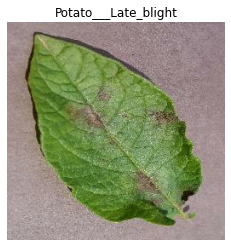

In [8]:
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

80% ==> training
20% ==> 10% validation, 10% test

In [9]:
train_size = 0.8
len(df)*train_size

54.400000000000006

In [10]:
train_ds = df.take(54)
len(train_ds)

54

In [11]:
test_ds = df.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(df)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 32):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=2)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [17]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [18]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
import pandas as pd
df = pd.DataFrame(train_ds)

In [20]:
df.head()

,0,1
0,"(((tf.Tensor([136. 125. 131.], shape=(3,), dty...","(tf.Tensor(1, shape=(), dtype=int32), tf.Tenso..."
1,"(((tf.Tensor([150. 140. 151.], shape=(3,), dty...","(tf.Tensor(1, shape=(), dtype=int32), tf.Tenso..."
2,"(((tf.Tensor([142. 137. 144.], shape=(3,), dty...","(tf.Tensor(0, shape=(), dtype=int32), tf.Tenso..."
3,"(((tf.Tensor([ 98. 92. 102.], shape=(3,), dty...","(tf.Tensor(0, shape=(), dtype=int32), tf.Tenso..."
4,"(((tf.Tensor([203. 185. 181.], shape=(3,), dty...","(tf.Tensor(1, shape=(), dtype=int32), tf.Tenso..."


In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
#read image from disk and for next iteration 
#if we need same image it will keep in memory
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#scaling
resize_rescale = tf.keras.Sequential([
    #all the image have the same size then why to use??
    #when user input new image of different size then useful
    layers.experimental.preprocessing.Resizing(img_size, img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),
    
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
i_shape = (b_size, img_size, img_size, channels)

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),  activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(), 
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(5, activation='softmax')
])
model.build(i_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [29]:
history = model.fit(train_ds, 
          epochs= epochs, batch_size = b_size,
         verbose=1, validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 128s 2s/step - loss: 0.0562 - accuracy: 0.9792 - val_loss: 0.0754 - val_accuracy: 0.9792
Epoch 2/10
54/54 [==============================] - 130s 2s/step - loss: 0.0474 - accuracy: 0.9832 - val_loss: 0.0920 - val_accuracy: 0.9583
Epoch 3/10
54/54 [==============================] - 132s 2s/step - loss: 0.0597 - accuracy: 0.9815 - val_loss: 0.2167 - val_accuracy: 0.9375
Epoch 4/10
54/54 [==============================] - 132s 2s/step - loss: 0.0737 - accuracy: 0.9740 - val_loss: 0.0807 - val_accuracy: 0.9688
Epoch 5/10
54/54 [==============================] - 131s 2s/step - loss: 0.0394 - accuracy: 0.9861 - val_loss: 0.0772 - val_accuracy: 0.9688
Epoch 6/10
54/54 [==============================] - 132s 2s/step - loss: 0.0262 - accuracy: 0.9913 - val_loss: 0.0696 - val_accuracy: 0.9792
Epoch 7/10
54/54 [==============================] - 131s 2s/step - loss: 0.0279 - accuracy: 0.9913 - val_loss: 0.2127 - val_accuracy: 0.9479
Epoch 8/10
54

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 645ms/step - loss: 0.0481 - accuracy: 0.9883


In [28]:
scores

[0.048072826117277145, 0.98828125]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.9791666865348816,
 0.9832175970077515,
 0.9814814925193787,
 0.9739583134651184,
 0.9861111044883728,
 0.9913194179534912,
 0.9913194179534912,
 0.9855324029922485,
 0.9728009104728699,
 0.9982638955116272]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

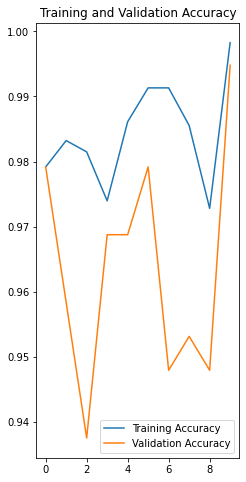

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label:  Potato___Early_blight
1/1 [==============================] - 1s 639ms/step
Potato___Early_blight


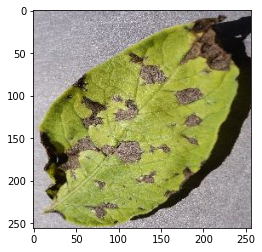

In [60]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [66]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)#create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 81ms/step


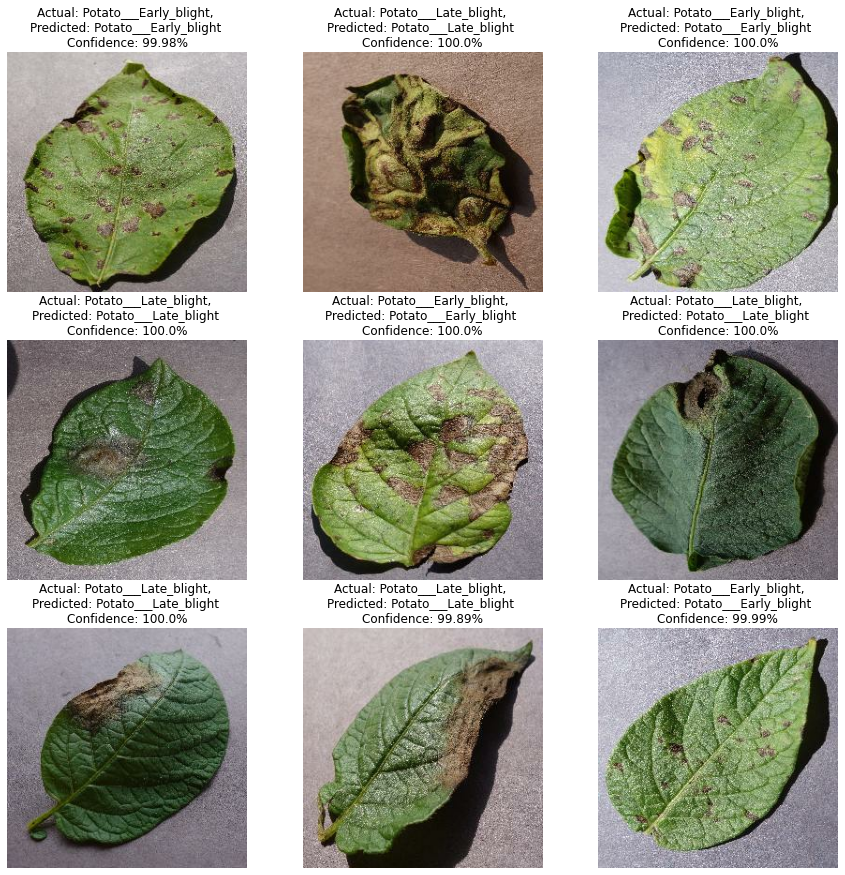

In [68]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class} \nConfidence: {confidence}%")
        plt.axis('off')
        

In [70]:
2+3

5

In [76]:
import os
max(os.listdir("model"))

'1'

In [71]:
model_version = 1
model.save(f"model/{model_version}")

INFO:tensorflow:Assets written to: model/1\assets


INFO:tensorflow:Assets written to: model/1\assets
